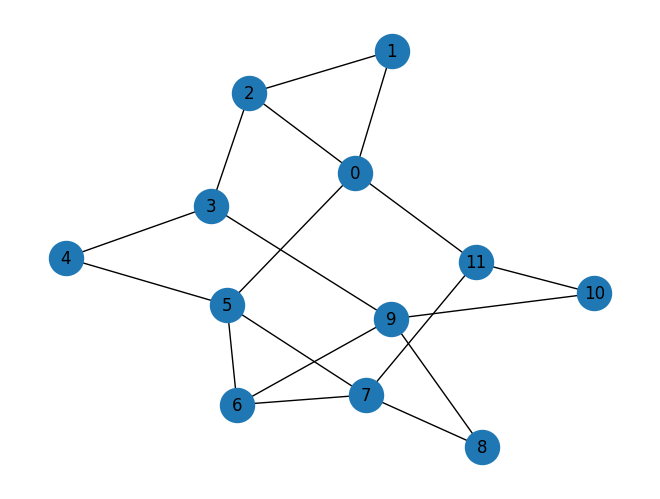

In [70]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 12

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0,11, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 10, 1.0), (10, 11, 1.0), (0, 2 ,1.0), (0, 5, 1.0), (7, 11, 1.0), (5, 7, 1.0), (3, 9, 1.0), (6, 9, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [71]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIZZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIIZZII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIIZZIIIII', 'IIIIZZIIIIII', 'IIIZZIIIIIII', 'IIZZIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII', 'IIIIIIIIIZIZ', 'IIIIIIZIIIIZ', 'ZIIIZIIIIIII', 'IIIIZIZIIIII', 'IIZIIIIIZIII', 'IIZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


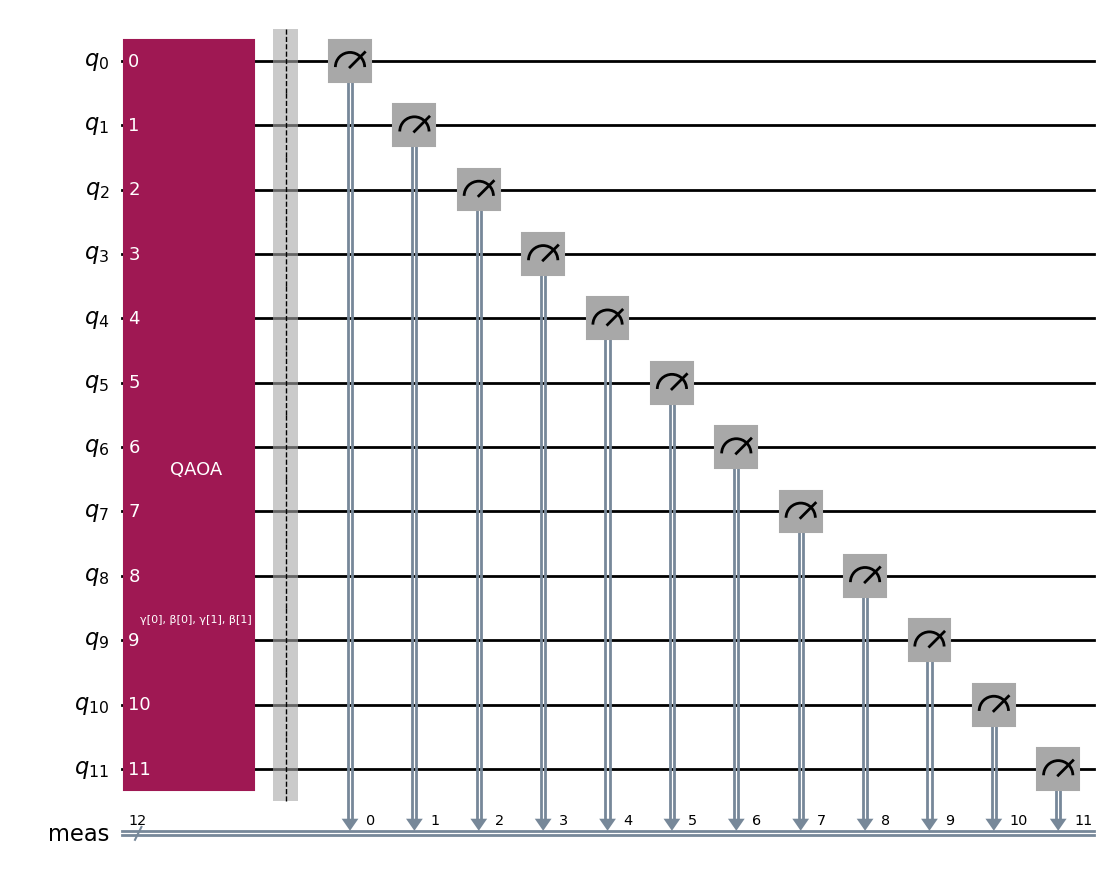

In [72]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [74]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

<IBMBackend('ibm_yonsei')>


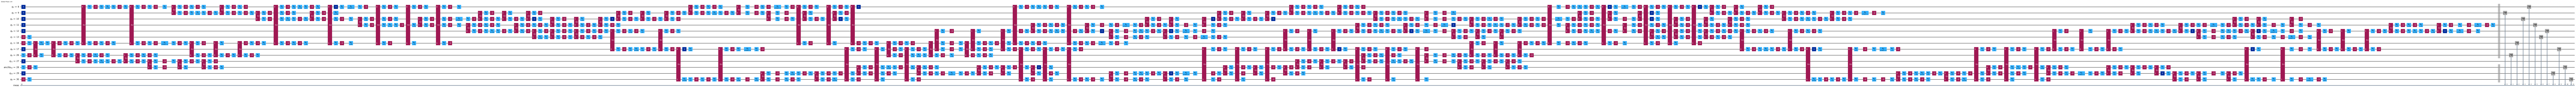

In [96]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.backend('ibm_yonsei')
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
QiskitRuntimeService.save_account(token="d8766950dc25dc637bf51880bb76dc2c059794f92f83266505ad3a32d33b81b00686b3d132afe11d7d407896e1191ca4e9339a97a12a184ea3e499b96c0df63e", 
                                  channel="ibm_quantum", 
                                  overwrite=True)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [97]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [99]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [109]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session) 
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.649005942104943
       x: [ 4.003e+00  1.899e+00  4.722e+00  1.310e+00]
    nfev: 39
   maxcv: 0.0


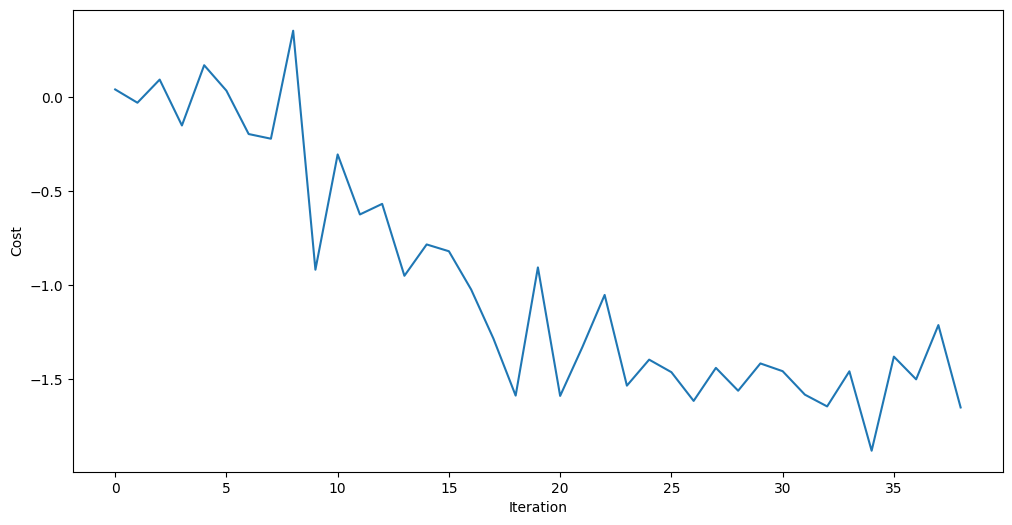

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

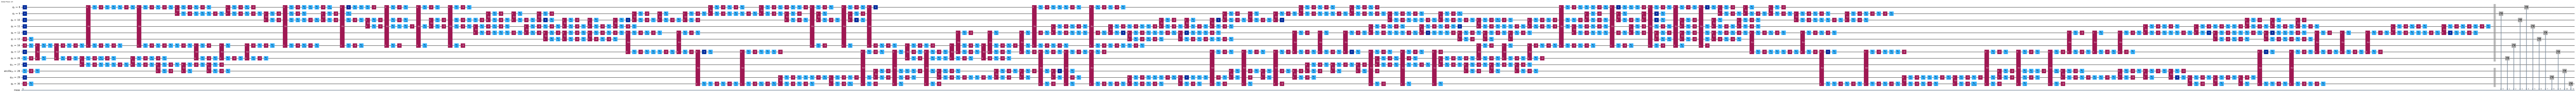

In [111]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [112]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{3202: 0.0003, 145: 0.0003, 3151: 0.0003, 147: 0.0004, 2819: 0.0001, 2969: 0.0005, 1894: 0.0003, 1988: 0.0002, 3133: 0.0002, 3443: 0.0003, 2729: 0.0005, 1699: 0.0005, 459: 0.0006, 2696: 0.0002, 3890: 0.0005, 849: 0.0007, 1930: 0.0004, 2737: 0.0004, 668: 0.0004, 4032: 0.0001, 2177: 0.0004, 536: 0.0001, 2901: 0.0003, 296: 0.0004, 3947: 0.0006, 1172: 0.0007, 2205: 0.0003, 3282: 0.0004, 392: 0.0002, 4069: 0.0001, 3480: 0.0004, 1428: 0.0006, 4021: 0.0002, 3751: 0.0003, 3194: 0.0003, 543: 0.0001, 1687: 0.0002, 755: 0.0001, 1041: 0.0003, 2225: 0.0004, 423: 0.0005, 700: 0.0002, 43: 0.0004, 2600: 0.0003, 1458: 0.0008, 3802: 0.0001, 2219: 0.0003, 1243: 0.0009, 2383: 0.0004, 634: 0.0006, 278: 0.0005, 2171: 0.0001, 624: 0.0005, 2742: 0.0006, 1605: 0.0003, 651: 0.001, 166: 0.0003, 2651: 0.0003, 3871: 0.0004, 269: 0.0003, 3219: 0.0003, 2713: 0.0004, 1267: 0.0002, 3355: 0.0004, 2699: 0.0005, 2904: 0.0005, 3469: 0.0007, 2141: 0.0003, 27: 0.0005, 3214: 0.0003, 3077: 0.0004, 1174: 0.0005, 3719: 0.0003, 

In [113]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]


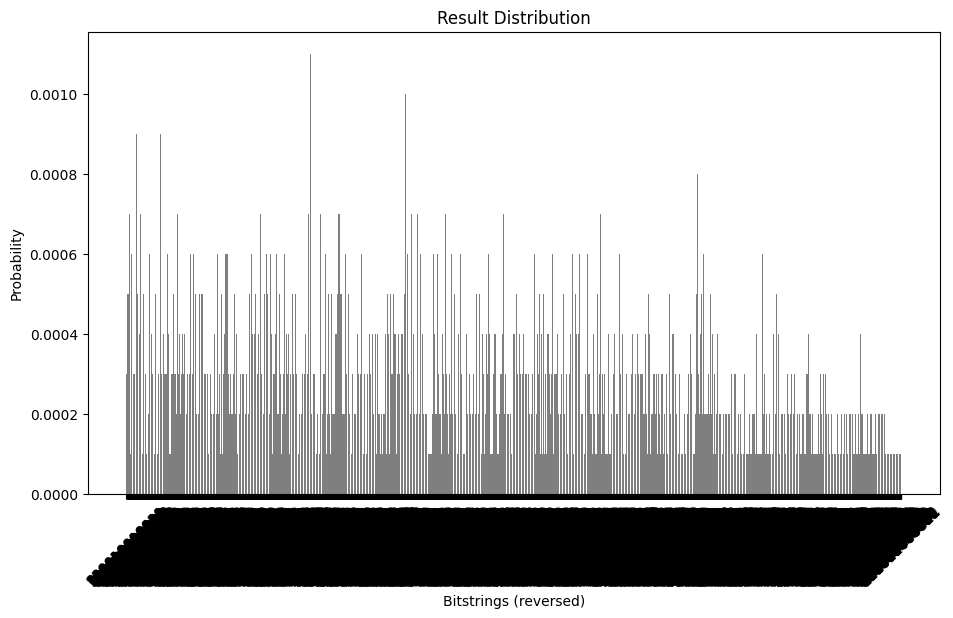

In [121]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")


plt.show()


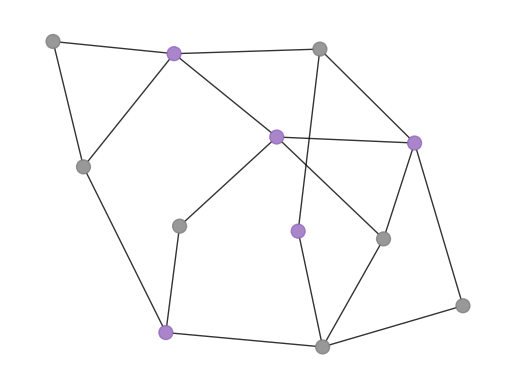

In [122]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [123]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 13
